### 1. Import necessary modules

In [1]:
import os
import numpy as np
import pandas as pd

import torch
from torch.utils.data import DataLoader
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
import tqdm

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Load and split data

In [3]:
# load data
input_data_dir = './data/lstm-inputs.pt'
target_data_dir = './data/lstm-target.pt'

input = torch.load(input_data_dir)
target = torch.load(target_data_dir)

In [4]:
# split data into training, validation and test
# training data (1980~2015)
train_end = 12*(2015-1980)+1
# train_input_list = input[12:train_end].tolist()
# train_ar_list = input[0:train_end-12].tolist()
# train_target_list = target[12:train_end].tolist()
train_list = [(input[i+12], target[i], target[i+12]) for i in range(train_end-12)]
train_dataloader = DataLoader(train_list)

# validation data (2016~2018)
val_end = 12*(2018-2015)
# val_input_list = input[train_end:val_end].tolist()
# val_target_list = target[train_end:val_end].tolist()
val_list = [(input[train_end+i], target[train_end+i-12], target[train_end+i]) for i in range(val_end)]
val_dataloader = DataLoader(val_list)

# test data (2019)
# test_input_list = input[val_end:].tolist()
# test_target_list = target[val_end:].tolist()
test_list = [(input[train_end+val_end+i], target[train_end+val_end+i-12], target[train_end+val_end+i]) for i in range(12)]
test_dataloader = DataLoader(test_list)

In [5]:
# Define months
train_start_month = []
for i in range(train_end):
    train_start_month.append(i%12+1)

val_start_month = []
for i in range(val_end):
    val_start_month.append(i%12+1)

test_start_month = []
for i in range(12):
    test_start_month.append(i%12+1)

### 3. LSTM

In [6]:
class CropYieldPredictor(nn.Module):

    def __init__(self, input_dim, hidden_dim, max_length =12):
        super(CropYieldPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.max_length = max_length
        self.pos_enc = self._generate_pos_enc(input_dim, max_length=12)
        self.compression = nn.Linear(input_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim)
        self.hidden2yield = nn.Linear(hidden_dim+1, 1)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # the first is the hidden "h"
        # the second is the cell "c"
        return (autograd.Variable(torch.zeros(1, 12, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, 12, self.hidden_dim)))

    @torch.no_grad()
    def _generate_pos_enc(self, hidden_dim, max_length=12):
        enc = torch.FloatTensor(max_length, hidden_dim).zero_() # Do not be confused with EncoderBlock.
                                                                 # It means an input matrix.
        # |enc| = (max_length=12, hidden_dim)

        pos = torch.arange(0, max_length).unsqueeze(-1).float() # column info of input matrix
        dim = torch.arange(0, hidden_dim // 2).unsqueeze(0).float() # row info of input matrix
        # |pos| = (max_length=12, 1)
        # |dim| = (1, hidden_dim // 2)

        enc[:, 0::2] = torch.sin(pos / 1e+4**dim.div(float(hidden_dim))) # dimensions which are even numbers
        enc[:, 1::2] = torch.cos(pos / 1e+4**dim.div(float(hidden_dim))) # dimensions which are odd numbers

        return enc

    def _position_encoding(self, x, start_month, init_pos=0):
        # |x| = (batch_size, length=12, hidden_dim)
        # |self.pos_enc| = (max_length=12, hidden_dim)
        assert x.size(-1) == self.pos_enc.size(-1)
        assert x.size(1) + init_pos <= self.max_length

        # |pos_enc| = (1, length, hidden_dim)
        pos_enc = self.pos_enc[init_pos:init_pos + x.size(1)].unsqueeze(0) # x.size(1) = length
                                                                           # training -> self.pos_enc[0:length]
                                                                           # Else, init_pos must be given!
        # in case input resnet features do not start with values of January
        if start_month != 1:
            first_half = pos_enc[:, start_month-1:, :]
            second_half = pos_enc[:, :start_month-1, :]
            pos_enc = torch.concat((first_half, second_half), dim=1)
        x = x + pos_enc.to(x.device) # Since |x| = (batch_size, length, hidden_dim), this line applies broadcasting.

        return x

    def forward(self, resnet_features, ar_term, start_month):
        x = self._position_encoding(resnet_features, start_month)
        x = self.compression(x)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        ar_term = torch.tensor([[ar_term]])
        crop_yield  = self.hidden2yield(torch.concat((lstm_out[:,-1,:], ar_term), dim=1))
        return crop_yield

### 4. Train

In [32]:
PATH_FOR_BEST_MODELS = './best_models'

if not os.path.exists(PATH_FOR_BEST_MODELS):
    os.makedirs(PATH_FOR_BEST_MODELS)

# training hyperparameters
# NUM_EPOCHS, HIDDEN_DIM, loss function, optimizer, lr
def train(epochs=30, hiddendim=64, lossfcn="mse", opt="adam", lr=1e-3):
    HIDDEN_DIM = hiddendim
    model = CropYieldPredictor(input_dim=input.shape[2], hidden_dim=HIDDEN_DIM).to(device)
    NUM_EPOCH = epochs
    loss_func_types = dict(
        mse=nn.MSELoss(),
        mae=nn.L1Loss()
    )
    loss_fcn = loss_func_types[lossfcn]
    lr = lr
    optimizers = dict(
        sgd = optim.SGD(model.parameters(), lr = lr),
        adam = optim.Adam(model.parameters(), lr = lr)
    )
    optimizer = optimizers[opt]
    BEST_MODEL_PATH = f"./best_models/epochs_{epochs}-hiddendim_{hiddendim}-lossfcn_{lossfcn}-opt_{opt}-lr_{lr}.pth"
    best_mse = float('inf')
    
    history_train = []
    history_val = []
    
    for epoch in range(1, NUM_EPOCH+1):
        model.train()
        cum_mse = 0
        cnt = 0
        with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:
            for resnet_features, ar_term, target in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                
                resnet_features, ar_term, target = resnet_features.to(device), ar_term.to(device), target.to(device)
                model.hidden = model.init_hidden()
                optimizer.zero_grad()
                output = model(resnet_features, ar_term, train_start_month[cnt])
                loss = loss_fcn(output, target)
                loss.backward()
                cum_mse += float(loss)
                avg_mse = cum_mse/(cnt+1)
                optimizer.step()
                cnt += 1
                tepoch.set_postfix(mse=avg_mse)
        
            history_train.append(avg_mse)

        model.eval()
        cum_mse_val = 0
        cnt_val = 0
        for resnet_features, ar_term, target in val_dataloader:
            resnet_features, ar_term, target = resnet_features.to(device), ar_term.to(device), target.to(device)
            model.hidden = model.init_hidden()
            output = model(resnet_features, ar_term, val_start_month[cnt_val])
            loss = loss_fcn(output, target)
            cum_mse_val += float(loss)
            cnt_val += 1
        avg_mse_val = cum_mse_val/(cnt_val)
        history_val.append(avg_mse_val)
        if avg_mse_val < best_mse:
            best_mse = avg_mse_val
            torch.save(model.state_dict(), BEST_MODEL_PATH)
            print(f"Best model saved at Epoch {epoch}")

    print("MSE: %.2f" % best_mse)
    plt.plot(history_train, label="Training Loss")
    plt.plot(history_val, label="Validation Loss")
    plt.legend()
    plt.show()

Epoch 1: 100%|██████████| 409/409 [00:08<00:00, 48.17batch/s, mse=0.0241]


Best model saved at Epoch 1


Epoch 2: 100%|██████████| 409/409 [00:08<00:00, 48.93batch/s, mse=0.0355]


Best model saved at Epoch 2


Epoch 3: 100%|██████████| 409/409 [00:08<00:00, 49.54batch/s, mse=0.0384]


Best model saved at Epoch 3


Epoch 4: 100%|██████████| 409/409 [00:08<00:00, 48.47batch/s, mse=0.0396]


Best model saved at Epoch 4


Epoch 5: 100%|██████████| 409/409 [00:08<00:00, 47.23batch/s, mse=0.0401]


Best model saved at Epoch 5


Epoch 6: 100%|██████████| 409/409 [00:08<00:00, 46.75batch/s, mse=0.0403]


Best model saved at Epoch 6


Epoch 7: 100%|██████████| 409/409 [00:09<00:00, 45.40batch/s, mse=0.0403]


Best model saved at Epoch 7


Epoch 8: 100%|██████████| 409/409 [00:09<00:00, 44.15batch/s, mse=0.0405]


Best model saved at Epoch 8


Epoch 9: 100%|██████████| 409/409 [00:08<00:00, 46.26batch/s, mse=0.0404]


Best model saved at Epoch 9


Epoch 10: 100%|██████████| 409/409 [00:09<00:00, 45.40batch/s, mse=0.0404]


Best model saved at Epoch 10


Epoch 11: 100%|██████████| 409/409 [00:09<00:00, 44.19batch/s, mse=0.0403]


Best model saved at Epoch 11


Epoch 12: 100%|██████████| 409/409 [00:09<00:00, 45.30batch/s, mse=0.0402]


Best model saved at Epoch 12


Epoch 13: 100%|██████████| 409/409 [00:08<00:00, 45.90batch/s, mse=0.0401]


Best model saved at Epoch 13


Epoch 14: 100%|██████████| 409/409 [00:09<00:00, 43.50batch/s, mse=0.0399]


Best model saved at Epoch 14


Epoch 15: 100%|██████████| 409/409 [00:10<00:00, 37.71batch/s, mse=0.0398]


Best model saved at Epoch 15


Epoch 16: 100%|██████████| 409/409 [00:09<00:00, 43.74batch/s, mse=0.0397]


Best model saved at Epoch 16


Epoch 17: 100%|██████████| 409/409 [00:09<00:00, 42.70batch/s, mse=0.0396]


Best model saved at Epoch 17


Epoch 18: 100%|██████████| 409/409 [00:09<00:00, 41.14batch/s, mse=0.0395]


Best model saved at Epoch 18


Epoch 19: 100%|██████████| 409/409 [00:09<00:00, 43.40batch/s, mse=0.0394]


Best model saved at Epoch 19


Epoch 20: 100%|██████████| 409/409 [00:09<00:00, 42.43batch/s, mse=0.0392]


Best model saved at Epoch 20


Epoch 21: 100%|██████████| 409/409 [00:09<00:00, 43.12batch/s, mse=0.0391]


Best model saved at Epoch 21


Epoch 22: 100%|██████████| 409/409 [00:08<00:00, 45.80batch/s, mse=0.039] 


Best model saved at Epoch 22


Epoch 23: 100%|██████████| 409/409 [00:08<00:00, 46.38batch/s, mse=0.0389]


Best model saved at Epoch 23


Epoch 24: 100%|██████████| 409/409 [00:09<00:00, 45.43batch/s, mse=0.0388]


Best model saved at Epoch 24


Epoch 25: 100%|██████████| 409/409 [00:08<00:00, 46.52batch/s, mse=0.0387]


Best model saved at Epoch 25


Epoch 26: 100%|██████████| 409/409 [00:08<00:00, 45.63batch/s, mse=0.0386]


Best model saved at Epoch 26


Epoch 27: 100%|██████████| 409/409 [00:08<00:00, 45.50batch/s, mse=0.0385]


Best model saved at Epoch 27


Epoch 28: 100%|██████████| 409/409 [00:08<00:00, 46.35batch/s, mse=0.0384]


Best model saved at Epoch 28


Epoch 29: 100%|██████████| 409/409 [00:08<00:00, 45.96batch/s, mse=0.0383]


Best model saved at Epoch 29


Epoch 100: 100%|██████████| 409/409 [00:08<00:00, 47.86batch/s, mse=0.0344]


MSE: 0.01


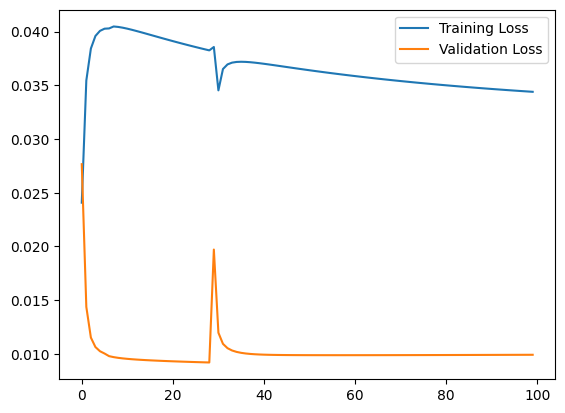

In [45]:
train(epochs=100, hiddendim=512, lossfcn='mse', opt='adam', lr=1e-3)

Epoch 1: 100%|██████████| 409/409 [00:03<00:00, 116.07batch/s, mse=0.0196]


Best model saved at Epoch 1


Epoch 2: 100%|██████████| 409/409 [00:03<00:00, 116.18batch/s, mse=0.0356]


Best model saved at Epoch 2


Epoch 15: 100%|██████████| 409/409 [00:03<00:00, 109.77batch/s, mse=0.0408]


Best model saved at Epoch 15


Epoch 16: 100%|██████████| 409/409 [00:03<00:00, 107.12batch/s, mse=0.0405]


Best model saved at Epoch 16


Epoch 17: 100%|██████████| 409/409 [00:03<00:00, 107.77batch/s, mse=0.0403]


Best model saved at Epoch 17


Epoch 18: 100%|██████████| 409/409 [00:03<00:00, 107.94batch/s, mse=0.04]  


Best model saved at Epoch 18


Epoch 19: 100%|██████████| 409/409 [00:03<00:00, 103.98batch/s, mse=0.0398]


Best model saved at Epoch 19


Epoch 20: 100%|██████████| 409/409 [00:03<00:00, 106.44batch/s, mse=0.0396]


Best model saved at Epoch 20


Epoch 22: 100%|██████████| 409/409 [00:03<00:00, 107.74batch/s, mse=0.0392]


Best model saved at Epoch 22


Epoch 24: 100%|██████████| 409/409 [00:03<00:00, 108.52batch/s, mse=0.0388]


Best model saved at Epoch 24


Epoch 25: 100%|██████████| 409/409 [00:03<00:00, 106.71batch/s, mse=0.0386]


Best model saved at Epoch 25


Epoch 26: 100%|██████████| 409/409 [00:03<00:00, 106.32batch/s, mse=0.0384]


Best model saved at Epoch 26


Epoch 27: 100%|██████████| 409/409 [00:03<00:00, 107.97batch/s, mse=0.0382]


Best model saved at Epoch 27


Epoch 28: 100%|██████████| 409/409 [00:03<00:00, 107.44batch/s, mse=0.0379]


Best model saved at Epoch 28


Epoch 29: 100%|██████████| 409/409 [00:03<00:00, 108.77batch/s, mse=0.0377]


Best model saved at Epoch 29


Epoch 30: 100%|██████████| 409/409 [00:03<00:00, 107.89batch/s, mse=0.0375]


Best model saved at Epoch 30


Epoch 31: 100%|██████████| 409/409 [00:03<00:00, 108.62batch/s, mse=0.0373]


Best model saved at Epoch 31


Epoch 32: 100%|██████████| 409/409 [00:03<00:00, 108.06batch/s, mse=0.0372]


Best model saved at Epoch 32


Epoch 33: 100%|██████████| 409/409 [00:03<00:00, 108.12batch/s, mse=0.037] 


Best model saved at Epoch 33


Epoch 34: 100%|██████████| 409/409 [00:03<00:00, 108.09batch/s, mse=0.0368]


Best model saved at Epoch 34


Epoch 35: 100%|██████████| 409/409 [00:03<00:00, 106.71batch/s, mse=0.0366]


Best model saved at Epoch 35


Epoch 37: 100%|██████████| 409/409 [00:03<00:00, 106.44batch/s, mse=0.0332]


Best model saved at Epoch 37


Epoch 38: 100%|██████████| 409/409 [00:03<00:00, 108.51batch/s, mse=0.0352]


Best model saved at Epoch 38


Epoch 39: 100%|██████████| 409/409 [00:03<00:00, 109.67batch/s, mse=0.0355]


Best model saved at Epoch 39


Epoch 40: 100%|██████████| 409/409 [00:03<00:00, 106.80batch/s, mse=0.0356]


Best model saved at Epoch 40


Epoch 41: 100%|██████████| 409/409 [00:03<00:00, 103.30batch/s, mse=0.0356]


Best model saved at Epoch 41


Epoch 42: 100%|██████████| 409/409 [00:03<00:00, 107.33batch/s, mse=0.0355]


Best model saved at Epoch 42


Epoch 43: 100%|██████████| 409/409 [00:03<00:00, 109.07batch/s, mse=0.0355]


Best model saved at Epoch 43


Epoch 44: 100%|██████████| 409/409 [00:03<00:00, 107.70batch/s, mse=0.0354]


Best model saved at Epoch 44


Epoch 45: 100%|██████████| 409/409 [00:03<00:00, 107.39batch/s, mse=0.0353]


Best model saved at Epoch 45


Epoch 46: 100%|██████████| 409/409 [00:03<00:00, 108.23batch/s, mse=0.0352]


Best model saved at Epoch 46


Epoch 47: 100%|██████████| 409/409 [00:03<00:00, 106.48batch/s, mse=0.0351]


Best model saved at Epoch 47


Epoch 48: 100%|██████████| 409/409 [00:03<00:00, 107.60batch/s, mse=0.035] 


Best model saved at Epoch 48


Epoch 49: 100%|██████████| 409/409 [00:03<00:00, 106.94batch/s, mse=0.0349]


Best model saved at Epoch 49


Epoch 50: 100%|██████████| 409/409 [00:03<00:00, 104.11batch/s, mse=0.0348]


Best model saved at Epoch 50


Epoch 51: 100%|██████████| 409/409 [00:03<00:00, 106.25batch/s, mse=0.0347]


Best model saved at Epoch 51


Epoch 52: 100%|██████████| 409/409 [00:03<00:00, 107.92batch/s, mse=0.0346]


Best model saved at Epoch 52


Epoch 53: 100%|██████████| 409/409 [00:03<00:00, 106.86batch/s, mse=0.0345]


Best model saved at Epoch 53


Epoch 54: 100%|██████████| 409/409 [00:03<00:00, 107.10batch/s, mse=0.0344]


Best model saved at Epoch 54


Epoch 55: 100%|██████████| 409/409 [00:03<00:00, 106.49batch/s, mse=0.0343]


Best model saved at Epoch 55


Epoch 56: 100%|██████████| 409/409 [00:03<00:00, 108.34batch/s, mse=0.0342]


Best model saved at Epoch 56


Epoch 57: 100%|██████████| 409/409 [00:03<00:00, 106.82batch/s, mse=0.0342]


Best model saved at Epoch 57


Epoch 58: 100%|██████████| 409/409 [00:03<00:00, 108.73batch/s, mse=0.0341]


Best model saved at Epoch 58


Epoch 59: 100%|██████████| 409/409 [00:03<00:00, 107.90batch/s, mse=0.034] 


Best model saved at Epoch 59


Epoch 60: 100%|██████████| 409/409 [00:03<00:00, 108.46batch/s, mse=0.0339]


Best model saved at Epoch 60


Epoch 61: 100%|██████████| 409/409 [00:03<00:00, 108.73batch/s, mse=0.0338]


Best model saved at Epoch 61


Epoch 62: 100%|██████████| 409/409 [00:03<00:00, 106.38batch/s, mse=0.0338]


Best model saved at Epoch 62


Epoch 63: 100%|██████████| 409/409 [00:03<00:00, 106.07batch/s, mse=0.0337]


Best model saved at Epoch 63


Epoch 64: 100%|██████████| 409/409 [00:03<00:00, 107.48batch/s, mse=0.0336]


Best model saved at Epoch 64


Epoch 65: 100%|██████████| 409/409 [00:03<00:00, 103.29batch/s, mse=0.0335]


Best model saved at Epoch 65


Epoch 66: 100%|██████████| 409/409 [00:04<00:00, 95.14batch/s, mse=0.0335] 


Best model saved at Epoch 66


Epoch 67: 100%|██████████| 409/409 [00:03<00:00, 102.87batch/s, mse=0.0334]


Best model saved at Epoch 67


Epoch 68: 100%|██████████| 409/409 [00:03<00:00, 103.83batch/s, mse=0.0333]


Best model saved at Epoch 68


Epoch 69: 100%|██████████| 409/409 [00:03<00:00, 108.49batch/s, mse=0.0332]


Best model saved at Epoch 69


Epoch 70: 100%|██████████| 409/409 [00:03<00:00, 107.55batch/s, mse=0.0332]


Best model saved at Epoch 70


Epoch 71: 100%|██████████| 409/409 [00:03<00:00, 106.32batch/s, mse=0.0331]


Best model saved at Epoch 71


Epoch 72: 100%|██████████| 409/409 [00:03<00:00, 102.46batch/s, mse=0.033] 


Best model saved at Epoch 72


Epoch 73: 100%|██████████| 409/409 [00:03<00:00, 103.53batch/s, mse=0.033] 


Best model saved at Epoch 73


Epoch 74: 100%|██████████| 409/409 [00:03<00:00, 108.77batch/s, mse=0.0329]


Best model saved at Epoch 74


Epoch 75: 100%|██████████| 409/409 [00:04<00:00, 100.84batch/s, mse=0.0329]


Best model saved at Epoch 75


Epoch 76: 100%|██████████| 409/409 [00:03<00:00, 106.38batch/s, mse=0.0328]


Best model saved at Epoch 76


Epoch 77: 100%|██████████| 409/409 [00:03<00:00, 107.05batch/s, mse=0.0327]


Best model saved at Epoch 77


Epoch 78: 100%|██████████| 409/409 [00:03<00:00, 106.07batch/s, mse=0.0327]


Best model saved at Epoch 78


Epoch 79: 100%|██████████| 409/409 [00:03<00:00, 109.06batch/s, mse=0.0326]


Best model saved at Epoch 79


Epoch 80: 100%|██████████| 409/409 [00:03<00:00, 107.87batch/s, mse=0.0326]


Best model saved at Epoch 80


Epoch 81: 100%|██████████| 409/409 [00:03<00:00, 105.72batch/s, mse=0.0325]


Best model saved at Epoch 81


Epoch 82: 100%|██████████| 409/409 [00:03<00:00, 106.78batch/s, mse=0.0325]


Best model saved at Epoch 82


Epoch 83: 100%|██████████| 409/409 [00:03<00:00, 106.50batch/s, mse=0.0324]


Best model saved at Epoch 83


Epoch 84: 100%|██████████| 409/409 [00:03<00:00, 107.53batch/s, mse=0.0324]


Best model saved at Epoch 84


Epoch 85: 100%|██████████| 409/409 [00:03<00:00, 107.33batch/s, mse=0.0323]


Best model saved at Epoch 85


Epoch 86: 100%|██████████| 409/409 [00:03<00:00, 106.79batch/s, mse=0.0323]


Best model saved at Epoch 86


Epoch 87: 100%|██████████| 409/409 [00:03<00:00, 108.95batch/s, mse=0.0322]


Best model saved at Epoch 87


Epoch 88: 100%|██████████| 409/409 [00:03<00:00, 106.83batch/s, mse=0.0322]


Best model saved at Epoch 88


Epoch 89: 100%|██████████| 409/409 [00:03<00:00, 105.22batch/s, mse=0.0321]


Best model saved at Epoch 89


Epoch 90: 100%|██████████| 409/409 [00:03<00:00, 107.85batch/s, mse=0.0321]


Best model saved at Epoch 90


Epoch 91: 100%|██████████| 409/409 [00:03<00:00, 105.71batch/s, mse=0.032] 


Best model saved at Epoch 91


Epoch 92: 100%|██████████| 409/409 [00:03<00:00, 106.07batch/s, mse=0.032] 


Best model saved at Epoch 92


Epoch 93: 100%|██████████| 409/409 [00:03<00:00, 107.02batch/s, mse=0.0319]


Best model saved at Epoch 93


Epoch 94: 100%|██████████| 409/409 [00:03<00:00, 108.13batch/s, mse=0.0319]


Best model saved at Epoch 94


Epoch 95: 100%|██████████| 409/409 [00:03<00:00, 106.74batch/s, mse=0.0319]


Best model saved at Epoch 95


Epoch 96: 100%|██████████| 409/409 [00:03<00:00, 106.67batch/s, mse=0.0318]


Best model saved at Epoch 96


Epoch 97: 100%|██████████| 409/409 [00:03<00:00, 106.70batch/s, mse=0.0318]


Best model saved at Epoch 97


Epoch 98: 100%|██████████| 409/409 [00:03<00:00, 107.72batch/s, mse=0.0317]


Best model saved at Epoch 98


Epoch 99: 100%|██████████| 409/409 [00:03<00:00, 106.19batch/s, mse=0.0317]


Best model saved at Epoch 99


Epoch 100: 100%|██████████| 409/409 [00:03<00:00, 105.31batch/s, mse=0.0317]


Best model saved at Epoch 100
MSE: 0.01


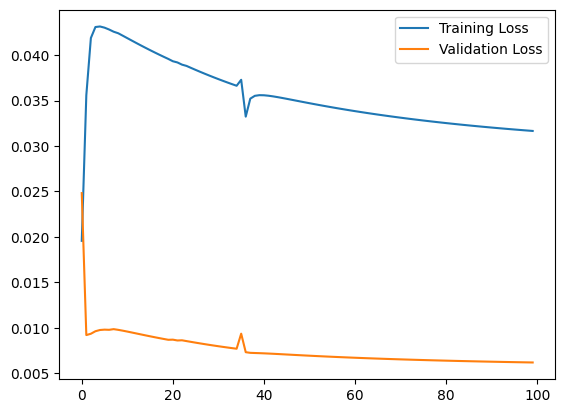

In [43]:
train(epochs=100, hiddendim=256, lossfcn='mse', opt='adam', lr=1e-3)

Epoch 1: 100%|██████████| 409/409 [00:02<00:00, 149.16batch/s, mse=0.0216]


Best model saved at Epoch 1


Epoch 17: 100%|██████████| 409/409 [00:02<00:00, 142.21batch/s, mse=0.0378]


Best model saved at Epoch 17


Epoch 33: 100%|██████████| 409/409 [00:03<00:00, 125.42batch/s, mse=0.0329]


Best model saved at Epoch 33


Epoch 34: 100%|██████████| 409/409 [00:02<00:00, 137.18batch/s, mse=0.0327]


Best model saved at Epoch 34


Epoch 35: 100%|██████████| 409/409 [00:03<00:00, 117.70batch/s, mse=0.0325]


Best model saved at Epoch 35


Epoch 36: 100%|██████████| 409/409 [00:03<00:00, 120.81batch/s, mse=0.0323]


Best model saved at Epoch 36


Epoch 37: 100%|██████████| 409/409 [00:03<00:00, 136.11batch/s, mse=0.0321]


Best model saved at Epoch 37


Epoch 38: 100%|██████████| 409/409 [00:03<00:00, 120.80batch/s, mse=0.0319]


Best model saved at Epoch 38


Epoch 39: 100%|██████████| 409/409 [00:03<00:00, 111.04batch/s, mse=0.0317]


Best model saved at Epoch 39


Epoch 40: 100%|██████████| 409/409 [00:03<00:00, 125.28batch/s, mse=0.0315]


Best model saved at Epoch 40


Epoch 41: 100%|██████████| 409/409 [00:03<00:00, 134.00batch/s, mse=0.0313]


Best model saved at Epoch 41


Epoch 42: 100%|██████████| 409/409 [00:03<00:00, 126.40batch/s, mse=0.0311]


Best model saved at Epoch 42


Epoch 43: 100%|██████████| 409/409 [00:03<00:00, 124.53batch/s, mse=0.031] 


Best model saved at Epoch 43


Epoch 44: 100%|██████████| 409/409 [00:04<00:00, 92.04batch/s, mse=0.0308] 


Best model saved at Epoch 44


Epoch 45: 100%|██████████| 409/409 [00:03<00:00, 116.68batch/s, mse=0.0306]


Best model saved at Epoch 45


Epoch 46: 100%|██████████| 409/409 [00:03<00:00, 132.37batch/s, mse=0.0305]


Best model saved at Epoch 46


Epoch 47: 100%|██████████| 409/409 [00:03<00:00, 131.82batch/s, mse=0.0303]


Best model saved at Epoch 47


Epoch 48: 100%|██████████| 409/409 [00:03<00:00, 128.56batch/s, mse=0.0302]


Best model saved at Epoch 48


Epoch 49: 100%|██████████| 409/409 [00:03<00:00, 121.54batch/s, mse=0.03]  


Best model saved at Epoch 49


Epoch 50: 100%|██████████| 409/409 [00:03<00:00, 132.97batch/s, mse=0.0299]


Best model saved at Epoch 50


Epoch 51: 100%|██████████| 409/409 [00:03<00:00, 128.14batch/s, mse=0.0298]


Best model saved at Epoch 51


Epoch 52: 100%|██████████| 409/409 [00:03<00:00, 121.66batch/s, mse=0.0296]


Best model saved at Epoch 52


Epoch 53: 100%|██████████| 409/409 [00:03<00:00, 125.82batch/s, mse=0.0295]


Best model saved at Epoch 53


Epoch 54: 100%|██████████| 409/409 [00:02<00:00, 137.23batch/s, mse=0.0294]


Best model saved at Epoch 54


Epoch 55: 100%|██████████| 409/409 [00:02<00:00, 136.94batch/s, mse=0.0293]


Best model saved at Epoch 55


Epoch 56: 100%|██████████| 409/409 [00:02<00:00, 138.93batch/s, mse=0.0292]


Best model saved at Epoch 56


Epoch 57: 100%|██████████| 409/409 [00:03<00:00, 133.50batch/s, mse=0.029] 


Best model saved at Epoch 57


Epoch 58: 100%|██████████| 409/409 [00:03<00:00, 133.16batch/s, mse=0.0289]


Best model saved at Epoch 58


Epoch 59: 100%|██████████| 409/409 [00:03<00:00, 134.18batch/s, mse=0.0288]


Best model saved at Epoch 59


Epoch 60: 100%|██████████| 409/409 [00:03<00:00, 135.49batch/s, mse=0.0287]


Best model saved at Epoch 60


Epoch 61: 100%|██████████| 409/409 [00:03<00:00, 135.71batch/s, mse=0.0286]


Best model saved at Epoch 61


Epoch 62: 100%|██████████| 409/409 [00:02<00:00, 136.38batch/s, mse=0.0285]


Best model saved at Epoch 62


Epoch 63: 100%|██████████| 409/409 [00:02<00:00, 136.43batch/s, mse=0.0284]


Best model saved at Epoch 63


Epoch 64: 100%|██████████| 409/409 [00:03<00:00, 134.38batch/s, mse=0.0283]


Best model saved at Epoch 64


Epoch 65: 100%|██████████| 409/409 [00:02<00:00, 137.08batch/s, mse=0.0282]


Best model saved at Epoch 65


Epoch 66: 100%|██████████| 409/409 [00:03<00:00, 133.86batch/s, mse=0.0282]


Best model saved at Epoch 66


Epoch 67: 100%|██████████| 409/409 [00:02<00:00, 136.52batch/s, mse=0.0281]


Best model saved at Epoch 67


Epoch 68: 100%|██████████| 409/409 [00:03<00:00, 133.64batch/s, mse=0.028] 


Best model saved at Epoch 68


Epoch 69: 100%|██████████| 409/409 [00:02<00:00, 136.75batch/s, mse=0.0279]


Best model saved at Epoch 69


Epoch 70: 100%|██████████| 409/409 [00:03<00:00, 133.87batch/s, mse=0.0278]


Best model saved at Epoch 70


Epoch 71: 100%|██████████| 409/409 [00:02<00:00, 137.08batch/s, mse=0.0277]


Best model saved at Epoch 71


Epoch 72: 100%|██████████| 409/409 [00:02<00:00, 138.62batch/s, mse=0.0277]


Best model saved at Epoch 72


Epoch 73: 100%|██████████| 409/409 [00:02<00:00, 136.66batch/s, mse=0.0276]


Best model saved at Epoch 73


Epoch 74: 100%|██████████| 409/409 [00:02<00:00, 139.11batch/s, mse=0.0275]


Best model saved at Epoch 74


Epoch 75: 100%|██████████| 409/409 [00:02<00:00, 137.35batch/s, mse=0.0275]


Best model saved at Epoch 75


Epoch 76: 100%|██████████| 409/409 [00:02<00:00, 139.30batch/s, mse=0.0274]


Best model saved at Epoch 76


Epoch 77: 100%|██████████| 409/409 [00:02<00:00, 139.31batch/s, mse=0.0273]


Best model saved at Epoch 77


Epoch 78: 100%|██████████| 409/409 [00:02<00:00, 136.43batch/s, mse=0.0273]


Best model saved at Epoch 78


Epoch 79: 100%|██████████| 409/409 [00:02<00:00, 139.61batch/s, mse=0.0272]


Best model saved at Epoch 79


Epoch 80: 100%|██████████| 409/409 [00:02<00:00, 137.04batch/s, mse=0.0271]


Best model saved at Epoch 80


Epoch 81: 100%|██████████| 409/409 [00:02<00:00, 138.92batch/s, mse=0.0271]


Best model saved at Epoch 81


Epoch 82: 100%|██████████| 409/409 [00:02<00:00, 138.71batch/s, mse=0.027] 


Best model saved at Epoch 82


Epoch 83: 100%|██████████| 409/409 [00:02<00:00, 136.85batch/s, mse=0.0269]


Best model saved at Epoch 83


Epoch 84: 100%|██████████| 409/409 [00:02<00:00, 137.80batch/s, mse=0.0269]


Best model saved at Epoch 84


Epoch 85: 100%|██████████| 409/409 [00:03<00:00, 135.20batch/s, mse=0.0268]


Best model saved at Epoch 85


Epoch 86: 100%|██████████| 409/409 [00:02<00:00, 138.68batch/s, mse=0.0268]


Best model saved at Epoch 86


Epoch 87: 100%|██████████| 409/409 [00:02<00:00, 137.31batch/s, mse=0.0267]


Best model saved at Epoch 87


Epoch 88: 100%|██████████| 409/409 [00:02<00:00, 136.69batch/s, mse=0.0267]


Best model saved at Epoch 88


Epoch 89: 100%|██████████| 409/409 [00:02<00:00, 138.69batch/s, mse=0.0266]


Best model saved at Epoch 89


Epoch 90: 100%|██████████| 409/409 [00:02<00:00, 137.33batch/s, mse=0.0266]


Best model saved at Epoch 90


Epoch 91: 100%|██████████| 409/409 [00:02<00:00, 139.29batch/s, mse=0.0265]


Best model saved at Epoch 91


Epoch 92: 100%|██████████| 409/409 [00:02<00:00, 138.88batch/s, mse=0.0265]


Best model saved at Epoch 92


Epoch 93: 100%|██████████| 409/409 [00:02<00:00, 139.53batch/s, mse=0.0264]


Best model saved at Epoch 93


Epoch 94: 100%|██████████| 409/409 [00:02<00:00, 139.56batch/s, mse=0.0264]


Best model saved at Epoch 94


Epoch 95: 100%|██████████| 409/409 [00:02<00:00, 136.91batch/s, mse=0.0264]


Best model saved at Epoch 95


Epoch 96: 100%|██████████| 409/409 [00:02<00:00, 140.08batch/s, mse=0.0263]


Best model saved at Epoch 96


Epoch 97: 100%|██████████| 409/409 [00:02<00:00, 138.67batch/s, mse=0.0263]


Best model saved at Epoch 97


Epoch 98: 100%|██████████| 409/409 [00:02<00:00, 138.86batch/s, mse=0.0262]


Best model saved at Epoch 98


Epoch 99: 100%|██████████| 409/409 [00:02<00:00, 141.63batch/s, mse=0.0262]


Best model saved at Epoch 99


Epoch 100: 100%|██████████| 409/409 [00:02<00:00, 138.22batch/s, mse=0.0261]


Best model saved at Epoch 100
MSE: 0.01


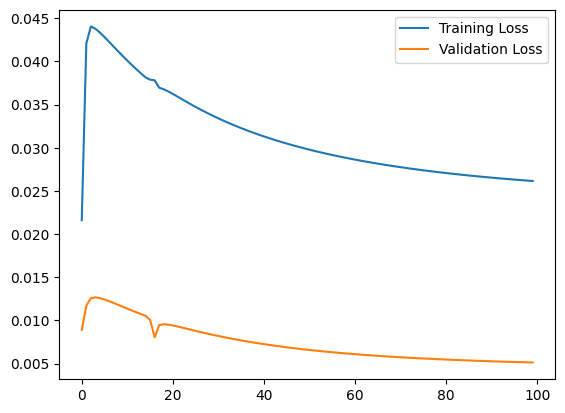

In [35]:
train(epochs=100, hiddendim=128, lossfcn='mse', opt='adam', lr=1e-3)

Epoch 1: 100%|██████████| 409/409 [00:02<00:00, 176.18batch/s, mse=0.0331]


Best model saved at Epoch 1


Epoch 23: 100%|██████████| 409/409 [00:02<00:00, 164.06batch/s, mse=0.0393]


Best model saved at Epoch 23


Epoch 24: 100%|██████████| 409/409 [00:02<00:00, 162.93batch/s, mse=0.0386]


Best model saved at Epoch 24


Epoch 25: 100%|██████████| 409/409 [00:02<00:00, 165.55batch/s, mse=0.038] 


Best model saved at Epoch 25


Epoch 26: 100%|██████████| 409/409 [00:02<00:00, 166.49batch/s, mse=0.0374]


Best model saved at Epoch 26


Epoch 27: 100%|██████████| 409/409 [00:02<00:00, 162.53batch/s, mse=0.0368]


Best model saved at Epoch 27


Epoch 28: 100%|██████████| 409/409 [00:02<00:00, 165.10batch/s, mse=0.0363]


Best model saved at Epoch 28


Epoch 29: 100%|██████████| 409/409 [00:02<00:00, 161.76batch/s, mse=0.0357]


Best model saved at Epoch 29


Epoch 30: 100%|██████████| 409/409 [00:02<00:00, 163.00batch/s, mse=0.0352]


Best model saved at Epoch 30


Epoch 31: 100%|██████████| 409/409 [00:02<00:00, 164.93batch/s, mse=0.0347]


Best model saved at Epoch 31


Epoch 32: 100%|██████████| 409/409 [00:02<00:00, 163.13batch/s, mse=0.0343]


Best model saved at Epoch 32


Epoch 33: 100%|██████████| 409/409 [00:02<00:00, 165.17batch/s, mse=0.0338]


Best model saved at Epoch 33


Epoch 34: 100%|██████████| 409/409 [00:02<00:00, 164.74batch/s, mse=0.0334]


Best model saved at Epoch 34


Epoch 35: 100%|██████████| 409/409 [00:02<00:00, 162.48batch/s, mse=0.033] 


Best model saved at Epoch 35


Epoch 36: 100%|██████████| 409/409 [00:02<00:00, 164.93batch/s, mse=0.0326]


Best model saved at Epoch 36


Epoch 37: 100%|██████████| 409/409 [00:02<00:00, 162.67batch/s, mse=0.0323]


Best model saved at Epoch 37


Epoch 38: 100%|██████████| 409/409 [00:02<00:00, 166.32batch/s, mse=0.0319]


Best model saved at Epoch 38


Epoch 39: 100%|██████████| 409/409 [00:02<00:00, 165.64batch/s, mse=0.0316]


Best model saved at Epoch 39


Epoch 40: 100%|██████████| 409/409 [00:02<00:00, 162.25batch/s, mse=0.0313]


Best model saved at Epoch 40


Epoch 41: 100%|██████████| 409/409 [00:02<00:00, 164.40batch/s, mse=0.031] 


Best model saved at Epoch 41


Epoch 42: 100%|██████████| 409/409 [00:02<00:00, 162.17batch/s, mse=0.0307]


Best model saved at Epoch 42


Epoch 43: 100%|██████████| 409/409 [00:02<00:00, 165.24batch/s, mse=0.0304]


Best model saved at Epoch 43


Epoch 44: 100%|██████████| 409/409 [00:02<00:00, 165.67batch/s, mse=0.0301]


Best model saved at Epoch 44


Epoch 45: 100%|██████████| 409/409 [00:02<00:00, 161.05batch/s, mse=0.0299]


Best model saved at Epoch 45


Epoch 61: 100%|██████████| 409/409 [00:02<00:00, 169.06batch/s, mse=0.0275]


Best model saved at Epoch 61


Epoch 62: 100%|██████████| 409/409 [00:02<00:00, 159.09batch/s, mse=0.0273]


Best model saved at Epoch 62


Epoch 63: 100%|██████████| 409/409 [00:02<00:00, 155.29batch/s, mse=0.0272]


Best model saved at Epoch 63


Epoch 64: 100%|██████████| 409/409 [00:02<00:00, 161.11batch/s, mse=0.0271]


Best model saved at Epoch 64


Epoch 65: 100%|██████████| 409/409 [00:02<00:00, 167.30batch/s, mse=0.027] 


Best model saved at Epoch 65


Epoch 66: 100%|██████████| 409/409 [00:02<00:00, 165.30batch/s, mse=0.0269]


Best model saved at Epoch 66


Epoch 67: 100%|██████████| 409/409 [00:02<00:00, 170.09batch/s, mse=0.0268]


Best model saved at Epoch 67


Epoch 68: 100%|██████████| 409/409 [00:02<00:00, 163.31batch/s, mse=0.0267]


Best model saved at Epoch 68


Epoch 69: 100%|██████████| 409/409 [00:02<00:00, 169.84batch/s, mse=0.0266]


Best model saved at Epoch 69


Epoch 70: 100%|██████████| 409/409 [00:02<00:00, 167.45batch/s, mse=0.0265]


Best model saved at Epoch 70


Epoch 71: 100%|██████████| 409/409 [00:02<00:00, 172.83batch/s, mse=0.0264]


Best model saved at Epoch 71


Epoch 72: 100%|██████████| 409/409 [00:02<00:00, 173.95batch/s, mse=0.0263]


Best model saved at Epoch 72


Epoch 73: 100%|██████████| 409/409 [00:02<00:00, 178.56batch/s, mse=0.0262]


Best model saved at Epoch 73


Epoch 74: 100%|██████████| 409/409 [00:02<00:00, 175.37batch/s, mse=0.0261]


Best model saved at Epoch 74


Epoch 75: 100%|██████████| 409/409 [00:02<00:00, 179.43batch/s, mse=0.026] 


Best model saved at Epoch 75


Epoch 76: 100%|██████████| 409/409 [00:02<00:00, 175.77batch/s, mse=0.0259]


Best model saved at Epoch 76


Epoch 77: 100%|██████████| 409/409 [00:02<00:00, 172.09batch/s, mse=0.0259]


Best model saved at Epoch 77


Epoch 78: 100%|██████████| 409/409 [00:02<00:00, 168.43batch/s, mse=0.0258]


Best model saved at Epoch 78


Epoch 79: 100%|██████████| 409/409 [00:02<00:00, 173.18batch/s, mse=0.0257]


Best model saved at Epoch 79


Epoch 80: 100%|██████████| 409/409 [00:02<00:00, 171.31batch/s, mse=0.0256]


Best model saved at Epoch 80


Epoch 81: 100%|██████████| 409/409 [00:02<00:00, 169.58batch/s, mse=0.0256]


Best model saved at Epoch 81


Epoch 82: 100%|██████████| 409/409 [00:02<00:00, 160.30batch/s, mse=0.0255]


Best model saved at Epoch 82


Epoch 83: 100%|██████████| 409/409 [00:02<00:00, 170.31batch/s, mse=0.0254]


Best model saved at Epoch 83


Epoch 84: 100%|██████████| 409/409 [00:02<00:00, 159.45batch/s, mse=0.0254]


Best model saved at Epoch 84


Epoch 85: 100%|██████████| 409/409 [00:02<00:00, 151.41batch/s, mse=0.0253]


Best model saved at Epoch 85


Epoch 86: 100%|██████████| 409/409 [00:02<00:00, 157.25batch/s, mse=0.0252]


Best model saved at Epoch 86


Epoch 87: 100%|██████████| 409/409 [00:02<00:00, 145.99batch/s, mse=0.0252]


Best model saved at Epoch 87


Epoch 88: 100%|██████████| 409/409 [00:02<00:00, 145.73batch/s, mse=0.0251]


Best model saved at Epoch 88


Epoch 89: 100%|██████████| 409/409 [00:02<00:00, 144.61batch/s, mse=0.0251]


Best model saved at Epoch 89


Epoch 90: 100%|██████████| 409/409 [00:02<00:00, 155.18batch/s, mse=0.025] 


Best model saved at Epoch 90


Epoch 91: 100%|██████████| 409/409 [00:02<00:00, 156.30batch/s, mse=0.025] 


Best model saved at Epoch 91


Epoch 92: 100%|██████████| 409/409 [00:02<00:00, 141.91batch/s, mse=0.0249]


Best model saved at Epoch 92


Epoch 93: 100%|██████████| 409/409 [00:02<00:00, 146.35batch/s, mse=0.0249]


Best model saved at Epoch 93


Epoch 94: 100%|██████████| 409/409 [00:02<00:00, 155.82batch/s, mse=0.0248]


Best model saved at Epoch 94


Epoch 95: 100%|██████████| 409/409 [00:02<00:00, 148.39batch/s, mse=0.0248]


Best model saved at Epoch 95


Epoch 96: 100%|██████████| 409/409 [00:02<00:00, 152.74batch/s, mse=0.0247]


Best model saved at Epoch 96


Epoch 97: 100%|██████████| 409/409 [00:02<00:00, 154.56batch/s, mse=0.0247]


Best model saved at Epoch 97


Epoch 98: 100%|██████████| 409/409 [00:02<00:00, 152.22batch/s, mse=0.0246]


Best model saved at Epoch 98


Epoch 99: 100%|██████████| 409/409 [00:02<00:00, 151.60batch/s, mse=0.0246]


Best model saved at Epoch 99


Epoch 100: 100%|██████████| 409/409 [00:02<00:00, 151.51batch/s, mse=0.0245]


Best model saved at Epoch 100
MSE: 0.01


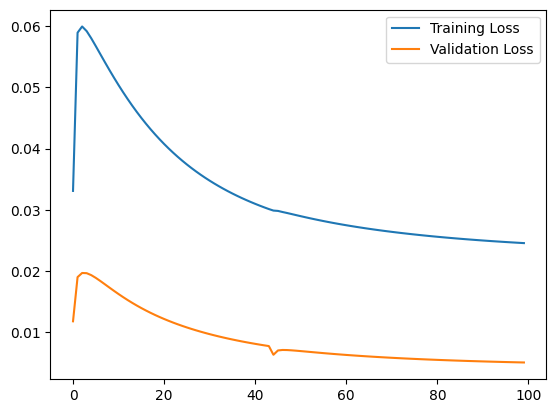

In [36]:
train(epochs=100, hiddendim=64, lossfcn='mse', opt='adam', lr=1e-3)

### 5. Test

In [40]:
def test(epochs, hiddendim, lossfcn, opt, lr):
    TEST_MODEL_PATH = f"./best_models/epochs_{epochs}-hiddendim_{hiddendim}-lossfcn_{lossfcn}-opt_{opt}-lr_{lr}.pth"
    model = CropYieldPredictor(input_dim=input.shape[2], hidden_dim=hiddendim).to(device)
    model.load_state_dict(torch.load(TEST_MODEL_PATH))
    loss_func_types = dict(
        mse=nn.MSELoss(),
        mae=nn.L1Loss()
    )
    loss_fcn = loss_func_types[lossfcn]

    model.eval()
    cum_mse_test = 0
    cnt_test = 0
    for resnet_features, ar_term, target in test_dataloader:
        resnet_features, ar_term, target = resnet_features.to(device), ar_term.to(device), target.to(device)
        model.hidden = model.init_hidden()
        output = model(resnet_features, ar_term, val_start_month[cnt_test])
        loss = loss_fcn(output, target)
        cum_mse_test += float(loss)
        cnt_test += 1
    avg_mse_test = cum_mse_test/(cnt_test)
    print(f"Test MSE: {avg_mse_test}")

In [46]:
test(100, 512, 'mse', 'adam', 1e-3)

Test MSE: 0.0005852324538864195


In [44]:
test(100, 256, 'mse', 'adam', 1e-3)

Test MSE: 0.00138481380417943


In [42]:
test(100, 128, 'mse', 'adam', 1e-3)

Test MSE: 0.0050458903424441814


In [41]:
test(100, 64, 'mse', 'adam', 1e-3)

Test MSE: 0.005677593406289816


c:\Users\1suof\miniconda3\envs\dl4ds-final\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
